In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as sps
import pandas as pd
import numpy as np
import csv

import plot_utils
from util import INST_NAME_ALIASES, binomial_confidence_interval, load_in_data
from scipy.stats import mannwhitneyu, ks_2samp, chisquare, chi2_contingency, ttest_ind, ranksums

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

%matplotlib inline

/Users/allisonmorgan/Dropbox/Faculty Social Mobility/code/plot_utils.py:39: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  rcParams['text.latex.preamble'] = [


In [2]:
respondents_zip = pd.read_csv('../data/coded_data/data_linked.csv', low_memory=False)

In [3]:
# https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2017-zip-code-data-soi
irs_data = pd.read_csv('../data/irs_data/yearly_irs_zip_data.csv', dtype={'ZIPCODE': str}, low_memory=False)
irs_data = irs_data[irs_data['ZIPCODE'].notna()]

irs_data['INFADJ_AGI'] = irs_data['INFADJ_AGI'].astype(float)
irs_data['AGI'] = irs_data['AGI'].astype(float)
irs_data['N'] = irs_data['N'].astype(float)
irs_data['AVG_ADJ_AGI'] = irs_data['INFADJ_AGI']/irs_data['N']

irs_data.head()

,YEAR,STATE,ZIPCODE,N,AGI,INFADJ_AGI,AVG_ADJ_AGI
0,1998,AL,35000,32.0,629.0,1005.0,31.406250
1,1998,AL,35001,84.0,1744.0,2786.0,33.166667
2,1998,AL,35004,2537.0,94515.0,151002.0,59.519905
3,1998,AL,35005,3772.0,121373.0,193912.0,51.408271
4,1998,AL,35006,1352.0,41937.0,67001.0,49.556953


In [4]:
respondents_zip['avg_income'].describe(), respondents_zip['avg_income'].isna().value_counts()

(count    3922.000000
 mean       93.842207
 std        99.223747
 min        16.744898
 25%        55.308129
 50%        72.719625
 75%       102.112986
 max      4550.650000
 Name: avg_income, dtype: float64,
 True     4087
 False    3922
 Name: avg_income, dtype: int64)

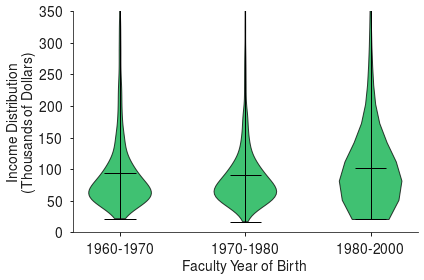

In [5]:
data = []
for year_start, year_end in [(1960, 1970), (1970, 1980), (1980, 2000)]:
    indices = np.where((np.array(respondents_zip['age_coded']) >= year_start) & \
                       (np.array(respondents_zip['age_coded']) < year_end))
    data.append(respondents_zip.loc[indices, 'avg_income'].dropna().values)

fig, ax = plt.subplots(1, 1, figsize=plot_utils.SINGLE_FIG_SIZE)
parts = ax.violinplot(data, showmeans = True, showextrema = True, showmedians = False, points=150)
for pc in parts['bodies']:
    pc.set_facecolor(plot_utils.ACCENT_COLOR)
    pc.set_edgecolor('black')
    pc.set_alpha(0.75)

# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['1960-1970', '1970-1980', '1980-2000'])
ax.set_ylim(0, 350)

ax.set_ylabel('Income Distribution\n(Thousands of Dollars)')
ax.set_xlabel('Faculty Year of Birth')

plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/income_generation.pdf', dpi=1000)

In [6]:
# Differences by discipline?
for dept in respondents_zip.likely_department.dropna().unique():
    print(dept, 
          (respondents_zip[respondents_zip.likely_department == dept]['avg_income'].median(),
           respondents_zip[respondents_zip.likely_department == dept]['avg_income'].mean(), 
           respondents_zip[respondents_zip.likely_department == dept]['avg_income'].sem()))

Business (71.5491142657603, 89.44113044572327, 2.6345051553181547)
History (77.93311876056953, 106.43750291960085, 3.6061545753311903)
Computer Science (75.4572256019559, 94.92343635206345, 3.4162209925504046)
Anthropology (72.23180375490881, 95.77959013965152, 5.542637429038246)
Physics and/or Astronomy (72.62528873145192, 92.82890319059894, 3.244115809306423)
Psychology (71.07815674115257, 95.42480120473027, 7.417357676233072)
Sociology (66.88000174542915, 81.29220218899641, 2.7413293988205814)
Biology (71.28872593950504, 91.2328917300102, 2.5108398675395143)


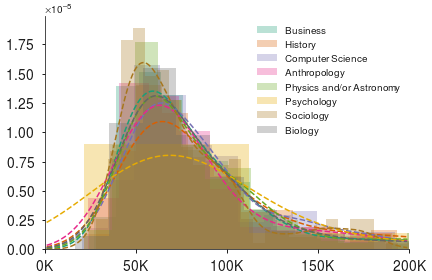

In [7]:
fig, ax = plt.subplots(1, 1, figsize=plot_utils.SINGLE_FIG_SIZE)

income_range = np.arange(1000, 200000, 1000)
unique_depts = respondents_zip.likely_department.dropna().unique()
category_colors = plt.get_cmap('Dark2')(np.linspace(0, 1, len(unique_depts)))
for i, dept in enumerate(unique_depts):
    dept_income = respondents_zip[respondents_zip.likely_department == dept]['avg_income'].dropna()*1000
    ax.hist(dept_income, bins=50, label=dept, density=True, alpha=0.3, color=category_colors[i])
    ax.plot(income_range, sps.gaussian_kde(dept_income, bw_method=0.2).pdf(income_range), label=None, 
            color=category_colors[i], linestyle='--')

plt.xlim([0, 200000])
plt.xticks([0, 50000, 100000, 150000, 200000], 
           [r'$0K$', r'$50K$', r'$100K$', r'$150K$', r'$200K$'])

plt.legend(fontsize=plot_utils.LEGEND_SIZE-2, frameon=False, ncol=1)
plot_utils.finalize(ax)
plt.tight_layout()
plt.savefig('../plots/disc_income_distribution.pdf', dpi=500) # This is an ugly plot

In [8]:
print(
    len(respondents_zip[respondents_zip.likely_department == 'History']['avg_income'].dropna()),
    len(respondents_zip[respondents_zip.likely_department == 'Sociology']['avg_income'].dropna())
)
ttest_ind(
    respondents_zip[respondents_zip.likely_department == 'History']['avg_income'].dropna(),
    respondents_zip[respondents_zip.likely_department == 'Sociology']['avg_income'].dropna(),
    equal_var=False
)

547 295


Ttest_indResult(statistic=5.551063851312313, pvalue=3.809733244831442e-08)

In [9]:
res = smf.ols('avg_income ~ age_coded', data=respondents_zip[['age_coded', 'avg_income']]).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_income   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.125
Date:                Fri, 18 Mar 2022   Prob (F-statistic):              0.289
Time:                        16:35:24   Log-Likelihood:                -23555.
No. Observations:                3915   AIC:                         4.711e+04
Df Residuals:                    3913   BIC:                         4.713e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -190.5801    268.280     -0.710      0.478    -716.563     335.403
age_coded      0.1446      0.136      1.060      0.289      -0.123       0.412
==============================================================================
Omnibus:                     9464.743   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        176996155.573
Skew:                          24.468   Prob(JB):                         0.00
Kurtosis:                    1043.500   Cond. No.                     3.33e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Perhaps, we should sample from the zipcode data however many responses we have to generate a plausible null distribution. Instead, we are just looping over all possible zips with income data from 1998, the year most faculty are matched on.

In [10]:
irs_data_98 = irs_data[(irs_data['YEAR'] == 1998) & ~irs_data['INFADJ_AGI'].isna()]
print(len(irs_data_98['ZIPCODE'].unique()), len(irs_data_98['ZIPCODE']))
irs_data_98.head()

40114 40117


,YEAR,STATE,ZIPCODE,N,AGI,INFADJ_AGI,AVG_ADJ_AGI
0,1998,AL,35000,32.0,629.0,1005.0,31.406250
1,1998,AL,35001,84.0,1744.0,2786.0,33.166667
2,1998,AL,35004,2537.0,94515.0,151002.0,59.519905
3,1998,AL,35005,3772.0,121373.0,193912.0,51.408271
4,1998,AL,35006,1352.0,41937.0,67001.0,49.556953


In [11]:
# Null model: consider a weighted average across all zip codes? 
N_total_returns = irs_data_98['N'].sum()
professor_pop_income = respondents_zip['avg_income'].dropna().values*1000
# total_income_by_zip = irs_data_98['INFADJ_AGI'].values*1000
# weights = irs_data_98['N']/N_total_returns
# general_pop_income = weights*total_income_by_zip

general_pop_income = []
for _, row in irs_data_98.iterrows():
    general_pop_income.extend(np.repeat(1000.0*row['AVG_ADJ_AGI'], row['N']))
    
print(len(professor_pop_income), len(general_pop_income), N_total_returns, 
      pd.Series(general_pop_income).mean(), 
      irs_data_98['AVG_ADJ_AGI'].mean(), 
      pd.Series(professor_pop_income).mean())

3922 121419870 121419870.0 69382.83210976899 61.21520794879827 93842.20735054971


In [12]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KernelDensity

# grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.1, 1.0, 30)}, cv=5, n_jobs=-2, verbose=True)
# grid.fit(np.array(professor_pop_income).reshape(-1, 1))
# print(grid.best_params_)

# grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.1, 1.0, 30)}, cv=5, n_jobs=-2, verbose=True)
# grid.fit(np.array(general_pop_income).reshape(-1, 1))
# print(grid.best_params_)

In [13]:
sampled_gen_pop = pd.Series(general_pop_income).sample(frac=0.01)

In [14]:
income_range = np.arange(1000, 200000, 1000)

# gen_pop_smoothed = sm.nonparametric.KDEUnivariate(general_pop_income).fit()
# fac_pop_smoothed = sm.nonparametric.KDEUnivariate(professor_pop_income).fit()

# gen_pop_smoothed = sps.gaussian_kde(pd.Series(general_pop_income), bw_method=0.001).pdf(income_range)
gen_pop_smoothed = sps.gaussian_kde(sampled_gen_pop, bw_method=0.1).pdf(income_range)
fac_pop_smoothed = sps.gaussian_kde(professor_pop_income, bw_method=0.1).pdf(income_range)

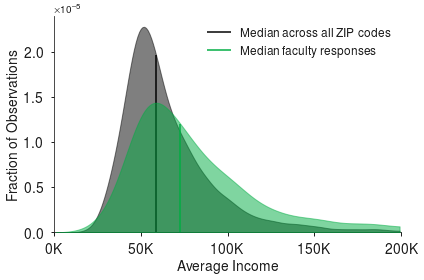

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=plot_utils.SINGLE_FIG_SIZE)

# plt.hist(general_pop_income, alpha=0.75, color='black', label='Across all zipcodes', density=True, bins=500)
plt.fill_between(income_range, gen_pop_smoothed, color='black', label=None, alpha=0.5, zorder=2)
plt.axvline(x=np.median(general_pop_income), ymin=0, ymax=0.82, color='black', 
            label='Median across all ZIP codes', zorder=1)

# plt.hist(professor_pop_income, alpha=0.75, color=plot_utils.ACCENT_COLOR, label='Faculty responses', 
#         density=True, bins=300)
plt.fill_between(income_range, fac_pop_smoothed, color=plot_utils.ACCENT_COLOR, label=None,
                 alpha=0.5, zorder=4)
plt.axvline(x=np.median(professor_pop_income), ymin=0, ymax=0.5, color=plot_utils.ACCENT_COLOR, 
            label='Median faculty responses', zorder=3)

plt.legend(fontsize=plot_utils.LEGEND_SIZE, frameon=False)
plt.ylim(bottom=0)
plt.xlim([0, 200000])
plt.xticks([0, 50000, 100000, 150000, 200000], 
           [r'$0K$', r'$50K$', r'$100K$', r'$150K$', r'$200K$'])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plot_utils.finalize(ax)
plt.xlabel('Average Income', size=plot_utils.LABEL_SIZE)
plt.ylabel('Fraction of Observations', size=plot_utils.LABEL_SIZE)
#plt.title('Distribution of Average Income by Zip Code', size=plot_utils.LABEL_SIZE)

plt.tight_layout()
plot_utils.finalize(ax)
plt.savefig('../plots/income_distribution.pdf', dpi=1000)

In [16]:
print(len(professor_pop_income), len(general_pop_income))
print(np.mean(professor_pop_income)/1000, np.mean(general_pop_income)/1000)
print(np.median(professor_pop_income)/1000, np.median(general_pop_income)/1000, 
      (np.median(professor_pop_income) - np.median(general_pop_income))/np.median(general_pop_income))

3922 121419870
93.84220735054971 69.382832109769
72.71962507056486 58.857875116495805 0.2355122390441867


In [17]:
ttest_ind(professor_pop_income, general_pop_income, equal_var=False)

Ttest_indResult(statistic=15.437683854169608, pvalue=3.0557518817325367e-52)

In [18]:
mannwhitneyu(professor_pop_income, general_pop_income)

MannwhitneyuResult(statistic=170029082930.0, pvalue=1.8582571156438055e-211)

In [19]:
len(professor_pop_income) + len(general_pop_income)

121423792

### Home ownership

In [20]:
respondents_zip['house'].replace({"Don’t know": np.nan}).value_counts(normalize=True)

We owned a home during all or most of the first 18 years of my life     0.757639
We rented a home during all or most of the first 18 years of my life    0.133668
We rented and owned a home about equally often                          0.108693
Name: house, dtype: float64

### Income versus age and current institutional prestige

(264.44151469531494, 33.111111111111114) (39.58582669514958, 33.35) Ttest_indResult(statistic=-0.6324435990741402, pvalue=0.5272904188464196)


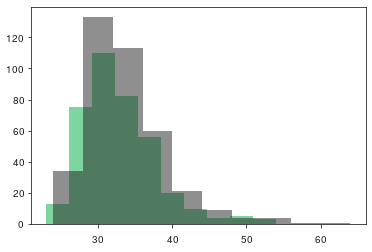

In [21]:
high_income = respondents_zip[respondents_zip['avg_income'] >= respondents_zip['avg_income'].quantile(0.9)]
high_income_years = (high_income['Tenure Track Year'] - high_income['age_coded']).dropna()
high_income_years.hist(alpha=0.5, color=plot_utils.ACCENT_COLOR)

low_income = respondents_zip[respondents_zip['avg_income'] < respondents_zip['avg_income'].quantile(0.1)]
low_income_years = (low_income['Tenure Track Year'] - low_income['age_coded']).dropna()
low_income_years.hist(alpha=0.5, color=plot_utils.ALMOST_BLACK, grid=False)

print((high_income['avg_income'].mean(), high_income_years.mean()),
      (low_income['avg_income'].mean(), low_income_years.mean()), 
      ttest_ind(high_income_years, low_income_years, equal_var=False))

In [22]:
# respondents_zip[['rank_scaled','likely_department']]

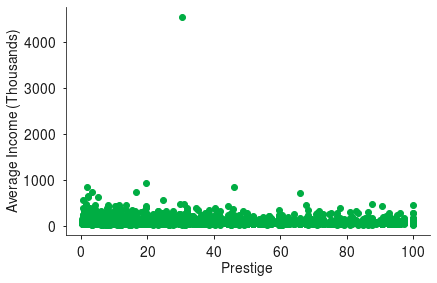

In [23]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=plot_utils.SINGLE_FIG_SIZE)

plt.scatter(respondents_zip['rank_scaled'], respondents_zip['avg_income'], color=plot_utils.ACCENT_COLOR)

plt.xlabel('Prestige', size=plot_utils.LABEL_SIZE)
plt.ylabel('Average Income (Thousands)', size=plot_utils.LABEL_SIZE)

plt.tight_layout()
plot_utils.finalize(ax)
plt.savefig('../plots/prestige_vs_income.pdf', dpi=1000)

In [24]:
results = smf.ols('rank_scaled ~ avg_income', 
                  data = respondents_zip[['rank_scaled', 'avg_income']]).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rank_scaled   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     23.21
Date:                Fri, 18 Mar 2022   Prob (F-statistic):           1.51e-06
Time:                        16:38:45   Log-Likelihood:                -16772.
No. Observations:                3553   AIC:                         3.355e+04
Df Residuals:                    3551   BIC:                         3.356e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9399      0.621     64.359      0.000      38.723      41.157
avg_income    -0.0215      0.004     -4.817      0.000      -0.030      -0.013
==============================================================================
Omnibus:                      339.498   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              268.538
Skew:                           0.583   Prob(JB):                     4.87e-59
Kurtosis:                       2.325   Cond. No.                         190.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
respondents_zip[['rank_scaled', 'inst_prestige', 'avg_income']].groupby(['inst_prestige']).agg(
    ['mean', 'sem', 'count'])

rank_scaled                  \
                                                       mean       sem count   
inst_prestige                                                                 
It is as prestigious as I currently deserve       35.746045  0.399745  4410   
It is less prestigious than I currently deserve   51.594964  0.756680  1136   
It is more prestigious than I currently deserve   21.585981  1.164244   374   

                                                avg_income                  
                                                      mean       sem count  
inst_prestige                                                               
It is as prestigious as I currently deserve      92.343621  1.273764  2701  
It is less prestigious than I currently deserve  90.506506  2.612329   653  
It is more prestigious than I currently deserve  97.532291  5.074937   239

In [26]:
respondents_zip[respondents_zip['gender_ans'] == 'Female']['inst_prestige'].value_counts(normalize=True)

It is as prestigious as I currently deserve        0.742456
It is less prestigious than I currently deserve    0.193795
It is more prestigious than I currently deserve    0.063748
Name: inst_prestige, dtype: float64

In [27]:
respondents_zip[respondents_zip['gender_ans'] == 'Male']['inst_prestige'].value_counts(normalize=True)

It is as prestigious as I currently deserve        0.736091
It is less prestigious than I currently deserve    0.206338
It is more prestigious than I currently deserve    0.057571
Name: inst_prestige, dtype: float64

### How does this compare to other professions?

In [28]:
# From data / doctors / msq2017report.pdf (question 35, p. 23)
doctors_parents_income = {
    r'$<$ 25K': 6.2, 
    r'$<$ 50K': 8.2, 
    r'$<$ 75K': 10.4, 
    r'$<$ 100K': 9.7, 
    r'$<$ 150K': 19.8, 
    r'$<$ 200K': 12.5, 
    r'$<$ 250K': 10.6, 
    r'$<$ 300K': 5.1, 
    r'$<$ 400K': 7.1, 
    r'$<$ 500K': 3.6, 
    '500K+': 6.9
}

In [29]:
respondents_avg_income_binned = {
    r'$<$ 25K': 0, r'$<$ 50K': 0, r'$<$ 75K': 0, r'$<$ 100K': 0, r'$<$ 150K': 0, r'$<$ 200K': 0, 
    r'$<$ 250K': 0, r'$<$ 300K': 0, r'$<$ 400K': 0, r'$<$ 500K': 0, '500K+': 0
}
for income_amt in respondents_zip['avg_income']:
    income_amt_abbrev = income_amt
    if income_amt_abbrev < 25:
        respondents_avg_income_binned[r'$<$ 25K'] += 1
    elif 25 <= income_amt_abbrev < 50:
        respondents_avg_income_binned[r'$<$ 50K'] += 1
    elif 50 <= income_amt_abbrev < 75:
        respondents_avg_income_binned[r'$<$ 75K'] += 1
    elif 75 <= income_amt_abbrev < 100:
        respondents_avg_income_binned[r'$<$ 100K'] += 1
    elif 100 <= income_amt_abbrev < 150:
        respondents_avg_income_binned[r'$<$ 150K'] += 1
    elif 150 <= income_amt_abbrev < 199:
        respondents_avg_income_binned[r'$<$ 200K'] += 1
    elif 200 <= income_amt_abbrev < 250:
        respondents_avg_income_binned[r'$<$ 250K'] += 1
    elif 250 <= income_amt_abbrev < 300:
        respondents_avg_income_binned[r'$<$ 300K'] += 1
    elif 300 <= income_amt_abbrev < 400:
        respondents_avg_income_binned[r'$<$ 400K'] += 1
    elif 400 <= income_amt_abbrev < 500:
        respondents_avg_income_binned[r'$<$ 500K'] += 1
    elif income_amt_abbrev >= 500:
        respondents_avg_income_binned['500K+'] += 1
#     else:
#         print(income_amt)

In [30]:
respondents_avg_income_binned, sum(respondents_avg_income_binned.values())

({'$<$ 25K': 10,
  '$<$ 50K': 590,
  '$<$ 75K': 1467,
  '$<$ 100K': 812,
  '$<$ 150K': 597,
  '$<$ 200K': 192,
  '$<$ 250K': 113,
  '$<$ 300K': 63,
  '$<$ 400K': 47,
  '$<$ 500K': 18,
  '500K+': 13},
 3922)

In [31]:
denom = sum(respondents_avg_income_binned.values())
for key, value in respondents_avg_income_binned.items():
    respondents_avg_income_binned[key] = 100.0*float(value)/denom

In [32]:
respondents_avg_income_binned

{'$<$ 25K': 0.25497195308516063,
 '$<$ 50K': 15.043345232024476,
 '$<$ 75K': 37.40438551759306,
 '$<$ 100K': 20.703722590515042,
 '$<$ 150K': 15.22182559918409,
 '$<$ 200K': 4.8954614992350844,
 '$<$ 250K': 2.881183069862315,
 '$<$ 300K': 1.606323304436512,
 '$<$ 400K': 1.198368179500255,
 '$<$ 500K': 0.4589495155532891,
 '500K+': 0.3314635390107088}

<ipython-input-33-caae2065b6c2>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.axes.set_xticklabels(list(doctors_parents_income.keys()))


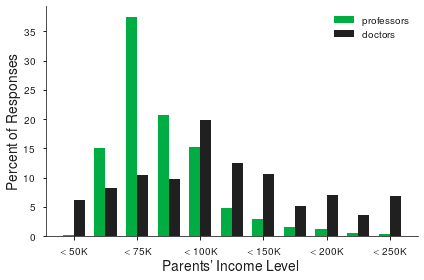

In [33]:
fig, ax = plt.subplots(1, 1, figsize=plot_utils.SINGLE_FIG_SIZE)

width = 0.35
plt.bar(np.arange(len(respondents_avg_income_binned))-width/2, respondents_avg_income_binned.values(), width,
        label = 'professors', color=plot_utils.ACCENT_COLOR)
plt.bar(np.arange(len(doctors_parents_income))+width/2, doctors_parents_income.values(), width,
        label = 'doctors', color=plot_utils.ALMOST_BLACK)

ax.axes.set_xticklabels(list(doctors_parents_income.keys()))
ax.set_ylabel("Percent of Responses")
ax.set_xlabel("Parents' Income Level")

plot_utils.finalize(ax)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('../plots/compare_income_distribution.pdf', dpi=1000)
plt.show()

In [34]:
sum(doctors_parents_income.values()), sum(respondents_avg_income_binned.values())

(100.09999999999998, 100.0)

In [35]:
chi2_contingency([list(respondents_avg_income_binned.values()), 
                  list(doctors_parents_income.values())], correction=False)

(49.483854087689636,
 3.32044186953283e-07,
 10,
 array([[ 3.22587304, 11.61586468, 23.89024763, 15.19426416, 17.50216172,
          8.69338406,  6.73722292,  3.35148591,  4.14711053,  2.02846053,
          3.61392481],
        [ 3.22909891, 11.62748055, 23.91413788, 15.20945843, 17.51966388,
          8.70207744,  6.74396015,  3.3548374 ,  4.15125765,  2.03048899,
          3.61753873]]))

### How does income correlate with educational levels?

In [36]:
respondents_zip.groupby(['parents_highest_edu_coded'])['avg_income'].describe()

,count,mean,std,min,25%,50%,75%,max
parents_highest_edu_coded,,,,,,,,
College: 1-3 years,333.0,75.320706,46.665728,16.744898,51.771951,63.808593,85.530989,573.519135
College: 4+ years,729.0,88.617301,63.437873,21.302483,56.314286,73.466067,97.891377,859.033173
Doctoral degree,942.0,102.541872,70.432260,23.765625,60.640338,81.318565,115.385960,859.033173
Elementary: 0-8 years,36.0,51.599344,19.578076,27.967213,37.551651,48.618142,56.488094,127.567617
High school: 1-3 years,50.0,61.511003,32.856917,31.777743,44.861858,53.665716,67.913953,233.572767
High school: 4 years,520.0,70.043456,51.396928,21.699909,48.500619,58.889783,76.813478,941.461538
Master's or professional degree,1306.0,107.228155,146.432201,21.600000,58.986656,78.966159,109.811672,4550.650000


In [37]:
mod = smf.ols('avg_income ~ C(parents_highest_edu_coded)', data=respondents_zip)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_income   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     14.68
Date:                Fri, 18 Mar 2022   Prob (F-statistic):           1.18e-16
Time:                        16:39:18   Log-Likelihood:                -23518.
No. Observations:                3916   AIC:                         4.705e+04
Df Residuals:                    3909   BIC:                         4.709e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          75.3207      5.385     13.988      0.000      64.764      85.877
C(parents_highest_edu_coded)[T.College: 4+ years]                  13.2966      6.499      2.046      0.041       0.555      26.038
C(parents_highest_edu_coded)[T.Doctoral degree]                    27.2212      6.264      4.345      0.000      14.939      39.503
C(parents_highest_edu_coded)[T.Elementary: 0-8 years]             -23.7214     17.239     -1.376      0.169     -57.520      10.077
C(parents_highest_edu_coded)[T.High school: 1-3 years]            -13.8097     14.903     -0.927      0.354     -43.027      15.408
C(parents_highest_edu_coded)[T.High school: 4 years]               -5.2772      6.896     -0.765      0.444     -18.798       8.244
C(parents_highest_edu_coded)[T.Master's or professional degree]    31.9074      6.032      5.290      0.000      20.081      43.734
==============================================================================
Omnibus:                     9555.190   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        189366151.616
Skew:                          25.033   Prob(JB):                         0.00
Kurtosis:                    1079.133   Cond. No.                         13.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
went_to_grad_school = respondents_zip.parents_highest_edu_coded.isin([
    "College: 4+ years", "Master's or professional degree", "Doctoral degree"])

income_went_to_grad = respondents_zip[(~respondents_zip.parents_highest_edu_coded.isna())& 
                                      went_to_grad_school]['avg_income'].dropna() 
income_did_not_grad = respondents_zip[(~respondents_zip.parents_highest_edu_coded.isna())& 
                                      ~went_to_grad_school]['avg_income'].dropna()

print(income_went_to_grad.median(), income_did_not_grad.median())

77.56398104265404 59.27234505614087


In [39]:
ttest_ind(income_went_to_grad, income_did_not_grad, equal_var=False)

Ttest_indResult(statistic=11.923298631755827, pvalue=3.6815502360102765e-32)

In [40]:
print(len(income_went_to_grad) + len(income_did_not_grad), len(income_went_to_grad), len(income_did_not_grad))
mannwhitneyu(income_went_to_grad, income_did_not_grad)

3916 2977 939


MannwhitneyuResult(statistic=907447.0, pvalue=1.55266308875837e-59)

### How does this relate to racial demographics?

In [41]:
white_prof_dist = respondents_zip[respondents_zip.white == 1]['avg_income']
black_prof_dist = respondents_zip[respondents_zip.black == 1]['avg_income']
hisp_prof_dist = respondents_zip[respondents_zip.hisp == 1]['avg_income']
asian_prof_dist = respondents_zip[respondents_zip.asian == 1]['avg_income']
native_prof_dist = respondents_zip[(respondents_zip.native == 1) | 
                                   (respondents_zip.hawaii == 1)]['avg_income']

In [42]:
for (key, dist) in [('white', white_prof_dist), ('black', black_prof_dist), ('hisp', hisp_prof_dist),
                    ('asian', asian_prof_dist), ('native', native_prof_dist)]:
    overview = dict(dist.describe())
    print(key, (overview['mean'], overview['std']), overview['count'])

white (94.78008299978163, 102.3372994424802) 3545.0
black (71.99111981595189, 44.40643966424128) 119.0
hisp (74.1593833648478, 46.60271302976384) 106.0
asian (103.28681741807131, 74.72559324019817) 153.0
native (61.96864682684891, 21.628909243781614) 29.0
